In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re
import tensorflow as tf
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/IMDB_Dataset.csv')

data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
import nltk
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def load_dataset():
    df = pd.read_csv('/content/drive/MyDrive/IMDB_Dataset.csv')
    x_data = df['review']       # Reviews/Input
    y_data = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case

    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object 

Sentiment
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


## Spit Dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
13242    [the, inspiration, naked, gun, movies, casts, ...
19871    [don, let, reviews, critics, imdb, users, mine...
42097    [much, usually, forgiven, period, pieces, ask,...
23242    [cause, it, s, crap, the, kind, movie, makes, ...
37505    [i, wanted, see, sarah, buffy, big, screen, i,...
                               ...                        
21574    [the, honey, i, shrunk, kids, franchise, huge,...
10134    [lucasarts, pulled, yet, another, beauty, seem...
27243    [within, first, minutes, dutch, thriller, lear...
31773    [i, seem, disagreeing, lot, folks, i, really, ...
30063    [combining, serious, drama, adequate, comedy, ...
Name: review, Length: 40000, dtype: object 

29137    [six, different, couples, six, different, love...
14081    [i, go, far, recommend, movie, since, problems...
31408    [after, wasting, hours, life, watching, movie,...
41218    [i, see, everyone, loves, film, much, true, go...
23671    [well, i, watch, tons, movies, one, really, su...
 

In [ ]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

## Tokenize and Pad/Truncate Reviews

In [ ]:
print(x_train)
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

13242    [the, inspiration, naked, gun, movies, casts, ...
19871    [don, let, reviews, critics, imdb, users, mine...
42097    [much, usually, forgiven, period, pieces, ask,...
23242    [cause, it, s, crap, the, kind, movie, makes, ...
37505    [i, wanted, see, sarah, buffy, big, screen, i,...
                               ...                        
21574    [the, honey, i, shrunk, kids, franchise, huge,...
10134    [lucasarts, pulled, yet, another, beauty, seem...
27243    [within, first, minutes, dutch, thriller, lear...
31773    [i, seem, disagreeing, lot, folks, i, really, ...
30063    [combining, serious, drama, adequate, comedy, ...
Name: review, Length: 40000, dtype: object
Encoded X Train
 [[    2  2816  1191 ...     0     0     0]
 [  330   183   719 ...     0     0     0]
 [   17   533  5912 ...  2775   318   316]
 ...
 [  645    23   135 ...     0     0     0]
 [    1   210 30213 ...     0     0     0]
 [ 7533   490   348 ...  1830   364  5602]] 

Encoded X Test
 [[ 1394  

# Build Architecture/Model

## LSTM Model

In [ ]:
from tensorflow.keras.utils import plot_model
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(964, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
plot_model(model, to_file='model1LSTM.png')
print(model.summary())
checkpoint1 = ModelCheckpoint(
    'LSTM1_2.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 130, 32)           2955936   
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_6 (Dense)             (None, 964)               62660     
                                                                 
 dense_7 (Dense)             (None, 1)                 965       
                                                                 
Total params: 3044393 (11.61 MB)
Trainable params: 3044393 (11.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(x_train, y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint1],validation_data=(x_test, y_test))

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.7488
Epoch 1: accuracy improved from -inf to 0.74885, saving model to LSTM1_2.h5
313/313 [==============================] - 36s 95ms/step - loss: 0.4599 - accuracy: 0.7488 - val_loss: 0.3049 - val_accuracy: 0.8698
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9245
Epoch 2: accuracy improved from 0.74885 to 0.92450, saving model to LSTM1_2.h5
313/313 [==============================] - 20s 62ms/step - loss: 0.2045 - accuracy: 0.9245 - val_loss: 0.3185 - val_accuracy: 0.8819
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9636
Epoch 3: accuracy improved from 0.92450 to 0.96360, saving model to LSTM1_2.h5
313/313 [==============================] - 14s 44ms/step - loss: 0.1107 - accuracy: 0.9636 - val_loss: 0.3779 - val_accuracy: 0.8746
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.0673 - accu

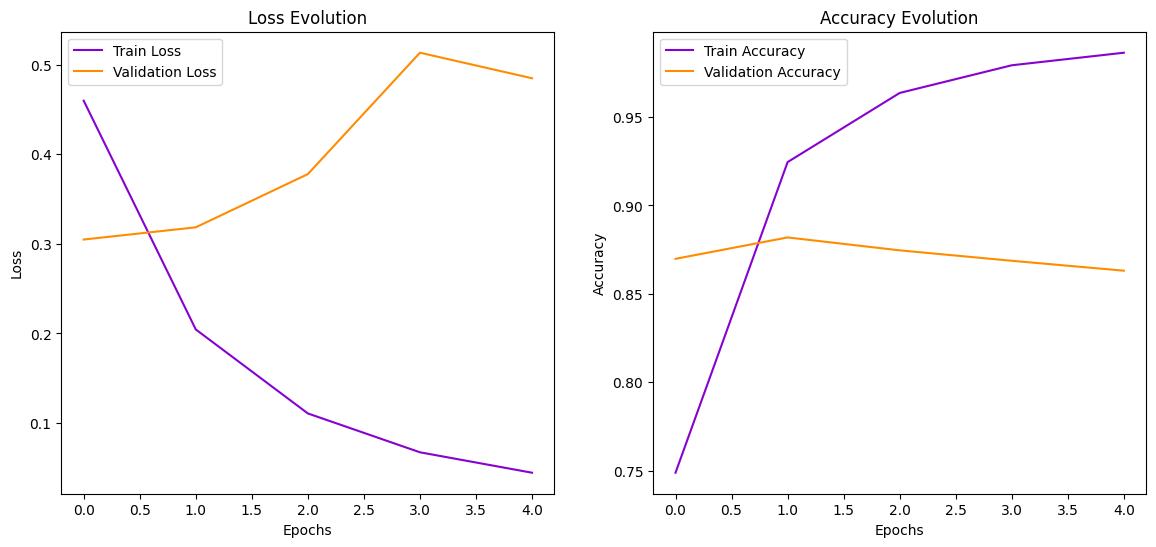

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
y_pred1 = (model.predict(x_test, batch_size = 128)> 0.5).astype("int32")

true = 0
for i, y in enumerate(y_test):
    if y == y_pred1[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred1) - true))
print('Accuracy: {}'.format(true/len(y_pred1)*100))

79/79 [==============================] - 1s 6ms/step
Correct Prediction: 8631
Wrong Prediction: 1369
Accuracy: 86.31


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test,y_pred1))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred1)

# Print confusion matrix with labels
print("Confusion Matrix:")
print("\t\tPredicted Positive\tPredicted Negative")
print(f"Actual Positive\t\t{cm[0][0]}\t\t\t{cm[0][1]}")
print(f"Actual Negative\t\t{cm[1][0]}\t\t\t{cm[1][1]}")

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      4955
           1       0.88      0.84      0.86      5045

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Confusion Matrix:
		Predicted Positive	Predicted Negative
Actual Positive		4375			580
Actual Negative		789			4256


## BiLSTM Model

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM, Reshape

# Define the model
model5 = Sequential()
model5.add(Embedding(total_words, EMBED_DIM, input_length=max_length))
model5.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model5.add(GlobalMaxPooling1D())
model5.add(Reshape((1, 64)))  # Reshape the tensor to (batch_size, timesteps, input_dim)
model5.add(Bidirectional(LSTM(LSTM_OUT)))
model5.add(Dense(32, activation='relu'))
model5.add(Dense(2, activation='sigmoid'))

# Compile the model
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint5 = ModelCheckpoint(
    'BiLSTM_2.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 130, 32)           2955936   
                                                                 
 conv1d_1 (Conv1D)           (None, 126, 64)           10304     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 reshape (Reshape)           (None, 1, 64)             0         
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense_10 (Dense)            (None, 32)               

In [ ]:
# Fit the model
history = model5.fit(x_train, y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint5],validation_data=(x_test, y_test))

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.4333 - accuracy: 0.7735
Epoch 1: accuracy improved from -inf to 0.77355, saving model to LSTM5_2.h5
313/313 [==============================] - 56s 92ms/step - loss: 0.4333 - accuracy: 0.7735 - val_loss: 0.3267 - val_accuracy: 0.8587
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9403
Epoch 2: accuracy improved from 0.77355 to 0.94033, saving model to LSTM5_2.h5
313/313 [==============================] - 17s 55ms/step - loss: 0.1609 - accuracy: 0.9403 - val_loss: 0.3249 - val_accuracy: 0.8646
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9927
Epoch 3: accuracy improved from 0.94033 to 0.99270, saving model to LSTM5_2.h5
313/313 [==============================] - 11s 34ms/step - loss: 0.0284 - accuracy: 0.9927 - val_loss: 0.4394 - val_accuracy: 0.8672
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9997
Epoch 4: accuracy improved from 0.99270 to 0.99967, saving model to LSTM5_2.h5
313/313 [==============================] - 8s 25ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 0.5388 - val_accuracy: 0.8698
Epoch 5/5
313/313 [==============================] - ETA: 0s - loss: 3.3913e-04 - accuracy

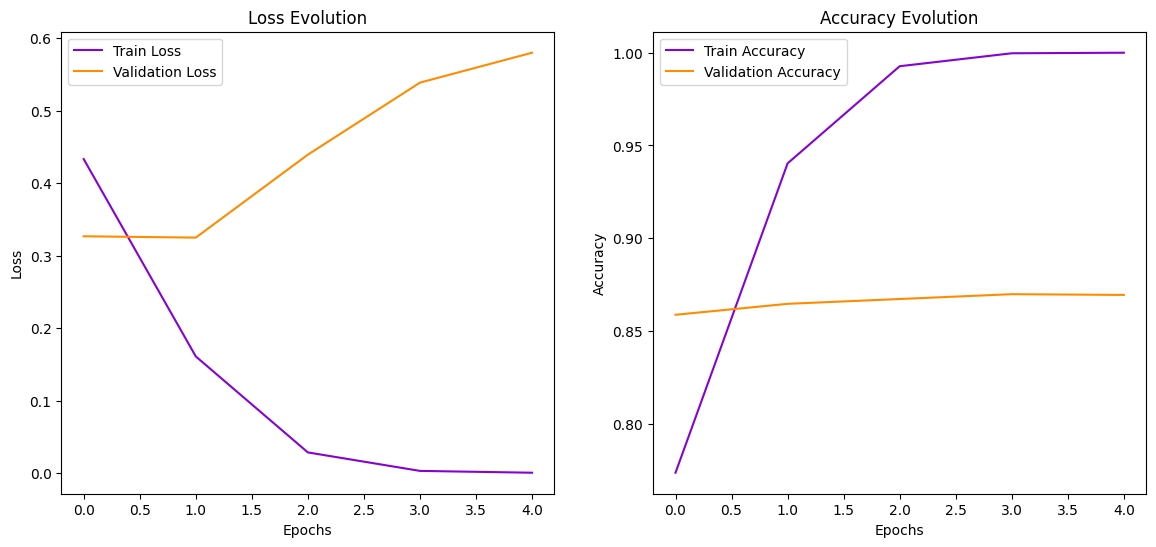

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
y_pred5 = np.argmax(model5.predict(x_test, batch_size=128), axis=1)

correct = np.sum(y_pred5 == y_test)
total = len(y_test)

print('Correct Predictions:', correct)
print('Wrong Predictions:', total - correct)
print('Accuracy:', correct / total * 100)

79/79 [==============================] - 1s 3ms/step
Correct Predictions: 8733
Wrong Predictions: 1267
Accuracy: 87.33


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test,y_pred5))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred5)

# Print confusion matrix with labels
print("Confusion Matrix:")
print("\t\tPredicted Positive\tPredicted Negative")
print(f"Actual Positive\t\t{cm[0][0]}\t\t\t{cm[0][1]}")
print(f"Actual Negative\t\t{cm[1][0]}\t\t\t{cm[1][1]}")

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4978
           1       0.87      0.89      0.88      5022

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix:
		Predicted Positive	Predicted Negative
Actual Positive		4288			690
Actual Negative		577			4445


# Load Saved Model

Load saved model and use it to predict a movie review statement's sentiment (positive or negative)

In [ ]:
loaded_model = load_model('LSTM1_2.h5')

In [ ]:
review ="Foolish hikers go camping in the Utah mountains only to run into a murderous, disfigured gypsy."

In [ ]:
# Pre-process input
regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)
print('Cleaned: ', review)

words = review.split(' ')
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]

print('Filtered: ', filtered)

Cleaned:  Foolish hikers go camping in the Utah mountains only to run into a murderous disfigured gypsy
Filtered:  ['foolish hikers go camping utah mountains run murderous disfigured gypsy']


In [ ]:
tokenize_words = token.texts_to_sequences(filtered)
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
print(tokenize_words)

[[ 6322 31149    62  7016 10265  4049   401  3858 11004  5944     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [ ]:
# fot LSTM model
result = loaded_model.predict(tokenize_words)
print(result)
if result >= 0.7:
    print('positive')
else:
    print('negative')

In [ ]:
# for BiLSTM model
result2 = loaded_model.predict(tokenize_words)
print(result2)

positive_prob = result2[0][1]
negative_prob = result2[0][0]

if positive_prob > negative_prob:
    print("Positive Sentiment")
else:
    print("Negative Sentiment")